In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import librosa
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

def audio_to_spectrogram(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, sr=None)
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        return mel_spec_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def augment_audio(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, sr=None)
        stretched_audio = librosa.effects.time_stretch(audio, rate=0.8)
        pitch_shifted_audio = librosa.effects.pitch_shift(audio, sr=sample_rate, n_steps=3)
        noise = np.random.randn(len(audio))
        noise_audio = audio + 0.005 * noise
        return [
            librosa.power_to_db(librosa.feature.melspectrogram(y=stretched_audio, sr=sample_rate), ref=np.max),
            librosa.power_to_db(librosa.feature.melspectrogram(y=pitch_shifted_audio, sr=sample_rate), ref=np.max),
            librosa.power_to_db(librosa.feature.melspectrogram(y=noise_audio, sr=sample_rate), ref=np.max)
        ]
    except Exception as e:
        print(f"Error augmenting {file_path}: {e}")
        return []

def resize_spectrogram(spectrogram, target_size=(128, 128)):
    resized = cv2.resize(spectrogram, target_size, interpolation=cv2.INTER_AREA)
    return resized

def load_data(data_paths):
    spectrograms = []
    labels = []

    for label, data_path in enumerate(data_paths):
        audio_files = [f for f in os.listdir(data_path) if f.endswith('.wav')]
        for file in audio_files:
            file_path = os.path.join(data_path, file)
            mel_spectrogram = audio_to_spectrogram(file_path)

            if mel_spectrogram is not None:
                resized_spectrogram = resize_spectrogram(mel_spectrogram)
                spectrograms.append(resized_spectrogram)
                labels.append(label)

                augmented_spectrograms = augment_audio(file_path)
                for aug_spec in augmented_spectrograms:
                    resized_aug_spectrogram = resize_spectrogram(aug_spec)
                    spectrograms.append(resized_aug_spectrogram)
                    labels.append(label)

    spectrograms = np.array(spectrograms)
    spectrograms = (spectrograms - np.mean(spectrograms)) / np.std(spectrograms)
    spectrograms = np.expand_dims(spectrograms, axis=-1)

    return spectrograms, np.array(labels)

train_data_paths = [
    '/content/drive/MyDrive/miniproject/birds/train/amerad',
    '/content/drive/MyDrive/miniproject/birds/train/comter',
    '/content/drive/MyDrive/miniproject/birds/train/rewbla'
]

val_data_paths = [
    '/content/drive/MyDrive/miniproject/birds/validation/amerad',
    '/content/drive/MyDrive/miniproject/birds/validation/comter',
    '/content/drive/MyDrive/miniproject/birds/validation/rewbla'
]

X_train, y_train = load_data(train_data_paths)
X_val, y_val = load_data(val_data_paths)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

model = Sequential([
    Input(shape=X_train[0].shape),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)

model.save('/content/drive/MyDrive/miniproject/bird_species_classifier_three_birds_v5.keras')




Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 38s 823ms/step - accuracy: 0.4477 - loss: 1.3458 - val_accuracy: 0.6133 - val_loss: 1.1175 - learning_rate: 1.0000e-04
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 822ms/step - accuracy: 0.7058 - loss: 1.0071 - val_accuracy: 0.6933 - val_loss: 0.9467 - learning_rate: 1.0000e-04
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 817ms/step - accuracy: 0.7580 - loss: 0.8560 - val_accuracy: 0.6917 - val_loss: 0.8963 - learning_rate: 1.0000e-04
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 808ms/step - accuracy: 0.7909 - loss: 0.7541 - val_accuracy: 0.7000 - val_loss: 0.9099 - learning_rate: 1.0000e-04
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 816ms/step - accuracy: 0.8069 - loss: 0.6858 - val_accuracy: 0.6867 - val_loss: 0.9076 - learning_rate: 1.0000e-04
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 826ms/step - accuracy: 0.8594 - loss: 0.5980 - val_accuracy: 0.6817 - val_loss: 0.9000 - learning_rate: 1.0000e-04
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 822ms/step - acc

In [ ]:
# Extracting the accuracy and loss
final_accuracy = history.history['accuracy'][-1]
final_loss = history.history['loss'][-1]

# Printing the final training accuracy and loss
print(f'Final Training Accuracy : {final_accuracy}')
print(f'Final Training Loss : {final_loss}')


Final Training Accuracy : 0.9715277552604675
Final Training Loss : 0.2633870244026184


In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plotting accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Call this function after training to plot the graphs
plot_training_history(history)


Please upload your audio file.


Saving XC244403.wav to XC244403.wav
Uploaded file: XC244403.wav
Model loaded successfully
Audio loaded successfully with sample rate: 44100
Spectrogram successfully generated and expanded for model input.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Model prediction output: [[0.00213045 0.02192876 0.97594076]]
Class 0 (amerad): 0.21%
Class 1 (comter): 2.19%
Class 2 (rewbla): 97.59%
Predicted class for the uploaded audio: rewbla


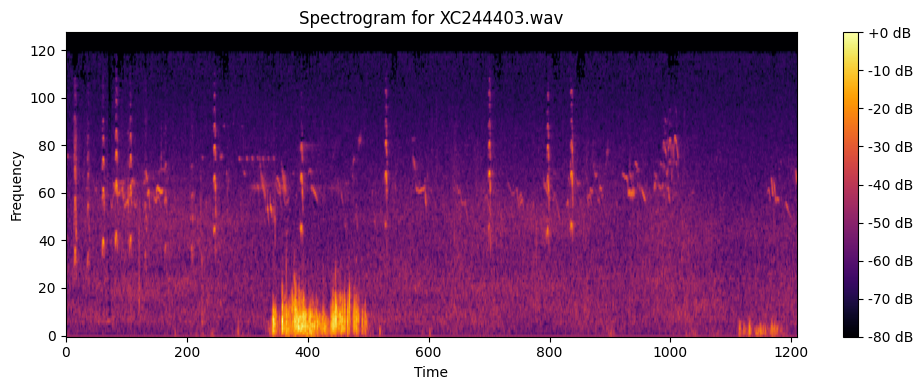

In [8]:
from google.colab import files
import librosa
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Step 1: Upload audio file from local system
print("Please upload your audio file.")
uploaded = files.upload()

# Get the file path of the uploaded file
file_path = None
for file_name in uploaded.keys():
    file_path = file_name  # Use the uploaded file name as path
    print(f"Uploaded file: {file_path}")

# Step 2: Function to preprocess and convert the uploaded audio to a spectrogram
def preprocess_audio(file_path, target_size=(128, 128)):
    try:
        # Load the audio file
        audio, sample_rate = librosa.load(file_path, sr=None)
        print(f"Audio loaded successfully with sample rate: {sample_rate}")

        # Create a Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Resize the spectrogram to target size
        resized_spectrogram = cv2.resize(mel_spectrogram_db, target_size, interpolation=cv2.INTER_AREA)

        # Normalize the spectrogram (same as in training)
        normalized_spectrogram = (resized_spectrogram - np.mean(resized_spectrogram)) / np.std(resized_spectrogram)

        return np.expand_dims(normalized_spectrogram, axis=-1), mel_spectrogram_db  # Add channel dimension and return raw spectrogram for visualization
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None

# Step 3: Load the trained model in TensorFlow's SavedModel format
try:
    model = tf.keras.models.load_model('/content/drive/MyDrive/miniproject/bird_species_classifier_three_birds_v5.keras')
    print("Model loaded successfully")
except Exception as e:
    print(f"Error loading model: {e}")

# Step 4: Preprocess the uploaded audio file
if file_path:
    test_spectrogram, mel_spectrogram_db = preprocess_audio(file_path)

    # Step 5: Check if the spectrogram was generated successfully
    if test_spectrogram is not None:
        # Add batch dimension (since model expects batch of data)
        test_spectrogram = np.expand_dims(test_spectrogram, axis=0)
        print("Spectrogram successfully generated and expanded for model input.")

        # Step 6: Make a prediction
        try:
            prediction = model.predict(test_spectrogram)
            print(f"Model prediction output: {prediction}")

            # Print class probabilities to see how confident the model is
            for i, prob in enumerate(prediction[0]):
                print(f"Class {i} ({['amerad','comter','rewbla'][i]}): {prob * 100:.2f}%")

            # Step 7: Get the predicted class
            predicted_class = np.argmax(prediction)
            bird_classes = ['amerad','comter','rewbla']  # Ensure that the class names match your training labels
            print(f"Predicted class for the uploaded audio: {bird_classes[predicted_class]}")

        except Exception as e:
            print(f"Error during model prediction: {e}")

        # Step 8: Plot the spectrogram
        plt.figure(figsize=(10, 4))
        plt.imshow(mel_spectrogram_db, aspect='auto', origin='lower', cmap='inferno')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Spectrogram for {file_path}")
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()
    else:
        print("Spectrogram generation failed.")
else:
    print("No file uploaded.")
